In [11]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Keras and TensorFlow layers (using TensorFlow for Keras)
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
org_col_names=["Date","City","PM2.5","PM10","NO","NO2","NOx","NH3","CO","SO2","O3"]
col_names = ["City","PM2.5","PM10", "NO","NO2","NOx","NH3","CO" ,"SO2","O3"]
dataset = pd.read_csv('airquality.csv',index_col=0)

dataset.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3
Date,,,,,,,,,,
01-01-2017,Hyderabad,61.25,100.46,7.54,39.37,8.27,15.38,0.25,6.08,69.11
02-01-2017,Hyderabad,47.21,80.12,9.69,52.00,10.85,24.87,0.33,20.73,47.61
03-01-2017,Hyderabad,65.45,132.09,11.01,58.68,13.66,18.06,0.31,22.99,50.37
04-01-2017,Hyderabad,116.03,197.89,12.20,58.20,12.48,26.16,0.15,37.31,56.42
05-01-2017,Hyderabad,96.21,162.27,10.97,57.60,13.18,36.67,0.14,25.88,45.66


In [12]:
# Data cleaning
dataset.columns = col_names
dataset.fillna(0, inplace=True)
dataset = dataset[24:] # drop the first day
print(dataset.head(5))
dataset.to_csv('cleaned_co.csv') # save new CSV

df = pd.read_csv('cleaned_co.csv', header=0, index_col=0)
df.describe()

dataset_columns = df.columns.tolist()
dataset_columns

                 City  PM2.5    PM10     NO    NO2    NOx    NH3        CO  \
Date                                                                         
25-01-2017  Hyderabad  76.94  144.81  10.14  47.79  11.21  18.46  0.115000   
26-01-2017  Hyderabad  64.21  108.56   9.54  32.92   8.41  14.62  0.113333   
27-01-2017  Hyderabad  56.14  100.40   9.47  41.90  10.18  15.15  0.111667   
28-01-2017  Hyderabad  68.79  131.75   8.46  43.74   7.53  18.29  0.110000   
29-01-2017  Hyderabad  85.73  157.28  10.50  53.72  12.36  28.21  0.108333   

              SO2     O3  
Date                      
25-01-2017   9.19  58.67  
26-01-2017   4.04  75.82  
27-01-2017   7.88  51.86  
28-01-2017  12.09  43.59  
29-01-2017  34.99  49.54  


['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

<Axes: xlabel='Date'>

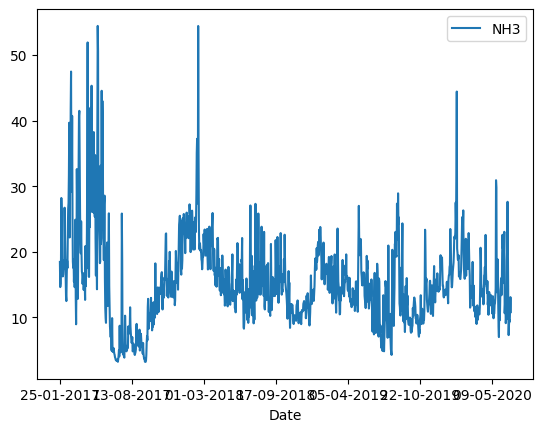

In [13]:
#Dropping other columns except variance column
df = df.drop(["City","CO","PM2.5","PM10","NO","NO2","NOx","SO2","O3"],axis = 1)
df.head()

df.plot()

In [14]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

scaled_dataset[:2,:]

array([[0.29761905],
       [0.2226776 ]])

In [15]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
  return X,Y

X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (1249, 1)
X (1249, 4, 1)


In [16]:
#Splitting the dataset
n_train = 365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (884, 4, 1)
X_test (365, 4, 1)
Y_train (884, 1)
Y_test (365, 1)


In [17]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50, return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units = 1))
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Train the model
model_lstm.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Y_pred_lstm = model_lstm.predict(X_test)
print('y_predicted',Y_pred_lstm.shape)
print('X_test' ,X_test.shape)
print('scaled Values shape', scaled_dataset.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0332
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0070
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0066
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 16

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 - 1s - 31ms/step - loss: 0.0489
Epoch 2/40
28/28 - 0s - 5ms/step - loss: 0.0178
Epoch 3/40
28/28 - 0s - 6ms/step - loss: 0.0070
Epoch 4/40
28/28 - 0s - 5ms/step - loss: 0.0059
Epoch 5/40
28/28 - 0s - 11ms/step - loss: 0.0057
Epoch 6/40
28/28 - 0s - 5ms/step - loss: 0.0055
Epoch 7/40
28/28 - 0s - 4ms/step - loss: 0.0052
Epoch 8/40
28/28 - 0s - 5ms/step - loss: 0.0049
Epoch 9/40
28/28 - 0s - 3ms/step - loss: 0.0047
Epoch 10/40
28/28 - 0s - 5ms/step - loss: 0.0044
Epoch 11/40
28/28 - 0s - 5ms/step - loss: 0.0043
Epoch 12/40
28/28 - 0s - 3ms/step - loss: 0.0042
Epoch 13/40
28/28 - 0s - 5ms/step - loss: 0.0041
Epoch 14/40
28/28 - 0s - 3ms/step - loss: 0.0040
Epoch 15/40
28/28 - 0s - 5ms/step - loss: 0.0039
Epoch 16/40
28/28 - 0s - 3ms/step - loss: 0.0039
Epoch 17/40
28/28 - 0s - 5ms/step - loss: 0.0039
Epoch 18/40
28/28 - 0s - 4ms/step - loss: 0.0038
Epoch 19/40
28/28 - 0s - 3ms/step - loss: 0.0038
Epoch 20/40
28/28 - 0s - 5ms/step - loss: 0.0038
Epoch 21/40
28/28 - 0s - 3ms/step - lo

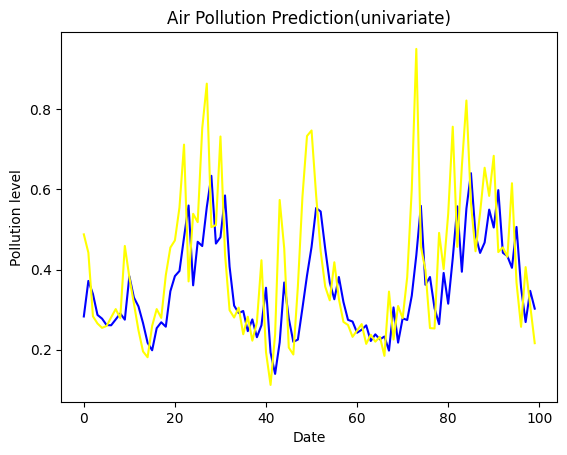

In [18]:
# MLP
import tensorflow as tf
from keras import optimizers
epochs = 40
batch = 256
lr = 0.0003
adam = tf.optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu',input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)

model_mlp.fit(X_train, Y_train, epochs=epochs, verbose=2)
Y_pred_mlp = model_mlp.predict(X_test)
print('y_predicted',Y_pred_mlp.shape)
print('X_test' ,X_test.shape)
print('scaled Values shape', scaled_dataset.shape)

#Plot the graph between actual vs predicted values
plt.plot(Y_pred_mlp[:100,:], color= 'blue')
plt.plot(Y_test[:100,:] , color = 'yellow')
plt.title("Air Pollution Prediction(univariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.show()

Train set shape (884, 4, 1)
Validation set shape (365, 4, 1)
Epoch 1/50
28/28 - 1s - 44ms/step - loss: 0.0153
Epoch 2/50
28/28 - 0s - 5ms/step - loss: 0.0064
Epoch 3/50
28/28 - 0s - 5ms/step - loss: 0.0062
Epoch 4/50
28/28 - 0s - 5ms/step - loss: 0.0061
Epoch 5/50
28/28 - 0s - 4ms/step - loss: 0.0059
Epoch 6/50
28/28 - 0s - 5ms/step - loss: 0.0059
Epoch 7/50
28/28 - 0s - 5ms/step - loss: 0.0059
Epoch 8/50
28/28 - 0s - 5ms/step - loss: 0.0058
Epoch 9/50
28/28 - 0s - 4ms/step - loss: 0.0058
Epoch 10/50
28/28 - 0s - 5ms/step - loss: 0.0059
Epoch 11/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 12/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 13/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 14/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 15/50
28/28 - 0s - 4ms/step - loss: 0.0057
Epoch 16/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 17/50
28/28 - 0s - 6ms/step - loss: 0.0057
Epoch 18/50
28/28 - 0s - 5ms/step - loss: 0.0058
Epoch 19/50
28/28 - 0s - 5ms/step - loss: 0.0057
Epoch 20/50
28/2

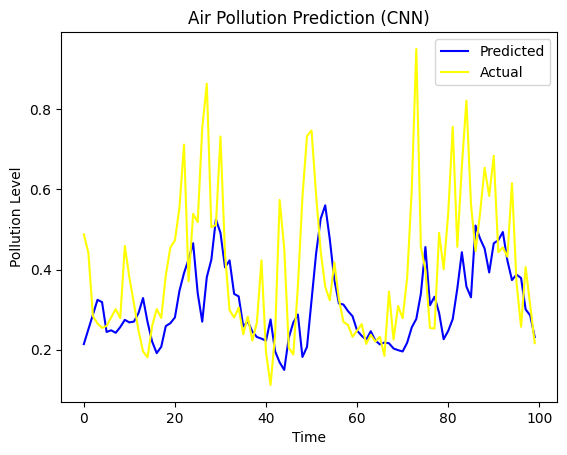

In [21]:
# Assuming that X_train, Y_train, X_test, Y_test, and scaled_dataset are properly defined

# Reshape the data for CNN input (1D convolution expects 3D input)
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

# Define the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

# Compile the model using the Adam optimizer
model_cnn.compile(loss='mse', optimizer='adam')

# Train the model
epochs = 50  # Define the number of epochs you want to train for
model_cnn.fit(X_train_series, Y_train, epochs=epochs, verbose=2)

# Make predictions on the test set
Y_pred_cnn = model_cnn.predict(X_test_series)

# Print the shapes to check
print('Predicted Y shape', Y_pred_cnn.shape)
print('Test X shape', X_test_series.shape)

# Plot the first 100 predictions vs. actual values
plt.plot(Y_pred_cnn[:100, :], color='blue', label='Predicted')
plt.plot(Y_test[:100, :], color='yellow', label='Actual')
plt.title("Air Pollution Prediction (CNN)")
plt.xlabel("Time")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()


Train set shape (884, 2, 2, 1)
Validation set shape (365, 2, 2, 1)
Epoch 1/50
28/28 - 3s - 100ms/step - loss: 0.0244
Epoch 2/50
28/28 - 0s - 11ms/step - loss: 0.0059
Epoch 3/50
28/28 - 0s - 5ms/step - loss: 0.0056
Epoch 4/50
28/28 - 0s - 5ms/step - loss: 0.0055
Epoch 5/50
28/28 - 0s - 5ms/step - loss: 0.0054
Epoch 6/50
28/28 - 0s - 5ms/step - loss: 0.0054
Epoch 7/50
28/28 - 0s - 5ms/step - loss: 0.0054
Epoch 8/50
28/28 - 0s - 6ms/step - loss: 0.0054
Epoch 9/50
28/28 - 0s - 6ms/step - loss: 0.0054
Epoch 10/50
28/28 - 0s - 5ms/step - loss: 0.0054
Epoch 11/50
28/28 - 0s - 5ms/step - loss: 0.0053
Epoch 12/50
28/28 - 0s - 5ms/step - loss: 0.0053
Epoch 13/50
28/28 - 0s - 5ms/step - loss: 0.0054
Epoch 14/50
28/28 - 0s - 5ms/step - loss: 0.0053
Epoch 15/50
28/28 - 0s - 5ms/step - loss: 0.0052
Epoch 16/50
28/28 - 0s - 11ms/step - loss: 0.0052
Epoch 17/50
28/28 - 0s - 5ms/step - loss: 0.0051
Epoch 18/50
28/28 - 0s - 5ms/step - loss: 0.0051
Epoch 19/50
28/28 - 0s - 5ms/step - loss: 0.0052
Epoch 2

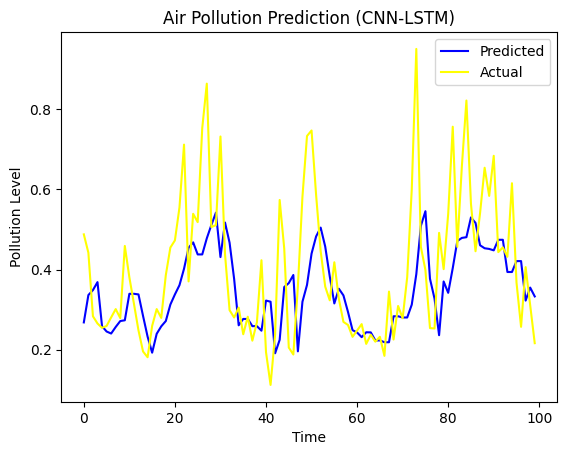

In [24]:
# Assuming that X_train, Y_train, X_test, Y_test, and scaled_dataset are already defined

# Reshape the data for CNN-LSTM input
subsequences = 2
timesteps = X_train_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

# Define the CNN-LSTM model
model_cnn_lstm = Sequential()

# TimeDistributed CNN layer
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                                   input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))

# LSTM layer
model_cnn_lstm.add(LSTM(50, activation='relu'))

# Dense output layer
model_cnn_lstm.add(Dense(1))

# Compile the model
model_cnn_lstm.compile(loss='mse', optimizer='adam')

# Train the model
epochs = 50  # Define the number of epochs
model_cnn_lstm.fit(X_train_series_sub, Y_train, epochs=epochs, verbose=2)

# Make predictions
Y_pred_cnn_lstm = model_cnn_lstm.predict(X_valid_series_sub)

# Print the shapes to verify
print('Predicted shape', Y_pred_cnn_lstm.shape)
print('Test X shape', X_test.shape)

# Plot the first 100 predictions vs actual values
plt.plot(Y_pred_cnn_lstm[:100, :], color='blue', label='Predicted')
plt.plot(Y_test[:100, :], color='yellow', label='Actual')
plt.title("Air Pollution Prediction (CNN-LSTM)")
plt.xlabel("Time")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()

Text(0, 0.5, 'NH3 level')

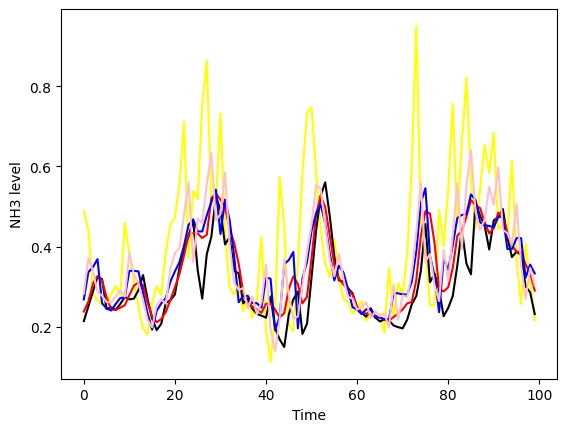

In [25]:
# Comparison
plt.plot(Y_test[:100,:] , color = 'yellow')
plt.plot(Y_pred_cnn[:100,:], color= 'black')
plt.plot(Y_pred_lstm[:100,:], color= 'red')
plt.plot(Y_pred_cnn_lstm[:100,:], color= 'blue')
plt.plot(Y_pred_mlp[:100,:], color= 'pink')
plt.xlabel("Time")
plt.ylabel("NH3 level")

In [26]:
# Error Metrics for MLP
print("MEAN SQUARE ERROR:", mean_squared_error(Y_test, Y_pred_mlp))
print("MEAN ABSOLUTE ERROR:", mean_absolute_error(Y_test, Y_pred_mlp))
print("MEAN ABSOLUTE PERCENTAGE ERROR:", mean_absolute_percentage_error(Y_test, Y_pred_mlp))
print("COEFFICENT OF DETERMINATION", r2_score(Y_test, Y_pred_mlp))

MEAN SQUARE ERROR: 0.011434918381734218
MEAN ABSOLUTE ERROR: 0.0673179369128285
MEAN ABSOLUTE PERCENTAGE ERROR: 378674152682.16565
COEFFICENT OF DETERMINATION 0.695559658424175


In [27]:
# Error Metrics for LSTM
print("MEAN SQUARE ERROR:", mean_squared_error(Y_test, Y_pred_lstm))
print("MEAN ABSOLUTE ERROR:", mean_absolute_error(Y_test, Y_pred_lstm))
print("MEAN ABSOLUTE PERCENTAGE ERROR:", mean_absolute_percentage_error(Y_test, Y_pred_lstm))
print("COEFFICENT OF DETERMINATION", r2_score(Y_test, Y_pred_lstm))

MEAN SQUARE ERROR: 0.016278183773315066
MEAN ABSOLUTE ERROR: 0.08742019957353526
MEAN ABSOLUTE PERCENTAGE ERROR: 1026235183387.6053
COEFFICENT OF DETERMINATION 0.5666137997016027


In [28]:
# Error Metrics for CNN
print("MEAN SQUARE ERROR:", mean_squared_error(Y_test, Y_pred_cnn))
print("MEAN ABSOLUTE ERROR:", mean_absolute_error(Y_test, Y_pred_cnn))
print("MEAN ABSOLUTE PERCENTAGE ERROR:", mean_absolute_percentage_error(Y_test, Y_pred_cnn))
print("COEFFICENT OF DETERMINATION", r2_score(Y_test, Y_pred_cnn))

MEAN SQUARE ERROR: 0.021320072828251792
MEAN ABSOLUTE ERROR: 0.09646223398702937
MEAN ABSOLUTE PERCENTAGE ERROR: 1464479139726.394
COEFFICENT OF DETERMINATION 0.43237983538015734


In [29]:
# Error Metrics for CNN-LSTM
print("MEAN SQUARE ERROR:", mean_squared_error(Y_test, Y_pred_cnn_lstm))
print("MEAN ABSOLUTE ERROR:", mean_absolute_error(Y_test, Y_pred_cnn_lstm))
print("MEAN ABSOLUTE PERCENTAGE ERROR:", mean_absolute_percentage_error(Y_test, Y_pred_cnn_lstm))
print("COEFFICENT OF DETERMINATION", r2_score(Y_test, Y_pred_cnn_lstm))

MEAN SQUARE ERROR: 0.013212049709679801
MEAN ABSOLUTE ERROR: 0.07623237749041015
MEAN ABSOLUTE PERCENTAGE ERROR: 679777858940.7758
COEFFICENT OF DETERMINATION 0.6482457685962355
